In [1]:
# Base requirements
!pip3 install farm-haystack[colab]==1.4.0
!pip3 install matplotlib
!pip3 install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 524 kB 38.3 MB/s 
     |████████████████████████████████| 43 kB 89 kB/s 
     |████████████████████████████████| 321 kB 65.8 MB/s 
     |████████████████████████████████| 10.7 MB 53.7 MB/s 
     |████████████████████████████████| 16.7 MB 62.6 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 5.6 MB 70.4 MB/s 
     |████████████████████████████████| 2.2 MB 56.9 MB/s 
     |████████████████████████████████| 3.3 MB 64.6 MB/s 
     |██████████████████████████████▎ | 834.1 MB 2.2 MB/s eta 0:00:22tcmalloc: large alloc 1147494400 bytes == 0x2cba000 @  0x7f22cfea8615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 

In [2]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [3]:
# Suppress Haystack logging
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# Question Answering

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="images/chapter07_marie-curie.png" id="marie-curie"/>

## Building a Review-Based QA System

### The Dataset

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="images/chapter07_phone.png" id="phone"/>

In [4]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [5]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [7]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [8]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [9]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

NameError: ignored

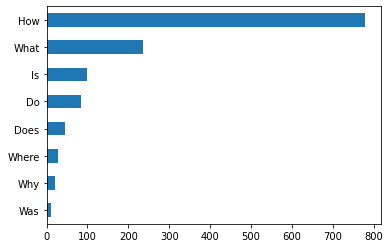

In [10]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [11]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### Sidebar: The Stanford Question Answering Dataset

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="images/chapter07_squad-sota.png" id="squad-sota"/>

### End sidebar

### Extracting Answers from Text

#### Span classification

<img alt="QA Head" caption="The span classification head for QA tasks" src="images/chapter07_qa-head.png" id="qa-head"/>

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="images/chapter07_squad-models.png" id="squad-models"/> 

#### Tokenizing text for QA

In [12]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [ ]:
#hide_input
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [14]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [15]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [16]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [17]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


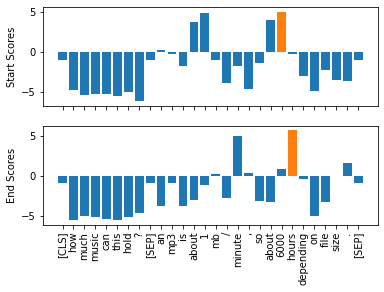

In [18]:
#hide_input
#id qa-scores
#caption Predicted logits for the start and end tokens—the token with the highest score is colored in orange

# The idea for this visualisation comes from https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

In [19]:
import torch 

start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [20]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516103744506836,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082966566085815,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253557562828064,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [21]:
pipe(question="Why is there no data?", context=context, 
     handle_impossible_answer=True)

{'score': 0.9068408012390137, 'start': 0, 'end': 0, 'answer': ''}

#### Dealing with long passages

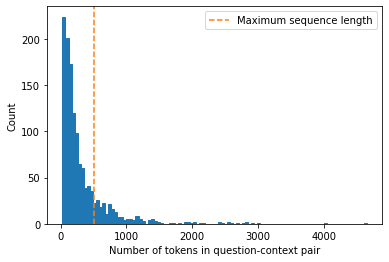

In [22]:
#hide_input
#id subjqa-dist
#caption Distribution of tokens for each question-context pair in the SubjQA training set
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="images/chapter07_sliding-window.png" id="sliding-window"/>

In [23]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [24]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [25]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



### Using Haystack to Build a QA Pipeline

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="images/chapter07_retriever-reader.png" id="retriever-reader"/>

#### Initializing a document store

In [26]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [27]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [28]:
# Alternative if Docker is installed
from haystack.utils import launch_es

launch_es()

INFO:haystack.modeling.model.optimization:apex not found, won't use it. See https://nvidia.github.io/apex/
ERROR:root:Failed to import 'magic' (from 'python-magic' and 'python-magic-bin' on Windows). FileTypeClassifier will not perform mimetype detection on extensionless files. Please make sure the necessary OS libraries are installed if you need this functionality.


In [29]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "0204b283b0d9",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "R033UPHmQOuCXDyflNG5Lg",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [30]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(return_embedding=True)

INFO:haystack.telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by calling disable_telemetry() or by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems on the documentation page. More information at https://haystack.deepset.ai/guides/telemetry


In [31]:
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

Since version 1.0 of Haystack, Documents now have a field `content`, which replaces the field `text`. This change was introduced because Documents have become more flexible and can also store tables in addition to texts.

In [32]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


#### Initializing a retriever

In Haystack 1.4 `ElasticsearchRetriever` was renamed to `BM25Retriever`. You can still use `ElasticsearchRetriever` for compatibility reasons in version 1.5 but it might be removed in future releases.

In [33]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [34]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [35]:
print(retrieved_docs[0])

<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never  ...'>


#### Initializing a reader

In [39]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/roberta-base-squad2" #alternative larger models: deepset/roberta-base-squad2-distilled or deepset/xlm-roberta-large-squad2 or the tiny distilled model: deepset/tinyroberta-squad2
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

INFO:haystack.modeling.utils:Using devices: CUDA:0
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find deepset/roberta-base-squad2 locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded deepset/roberta-base-squad2


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.infer:Got ya 2 parallel workers to do inference ...
INFO:haystack.modeling.infer: 0     0  
INFO:haystack.modeling.infer:/w\   /w\ 
INFO:haystack.modeling.infer:/'\   / \ 


In [40]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 4.9153571128845215, 'answers': [<Answer {'answer': '', 'type': 'extractive', 'score': 0.5798549715650971, 'context': None, 'offsets_in_document': [{'start': 0, 'end': 0}], 'offsets_in_context': [{'start': 0, 'end': 0}], 'document_id': None, 'meta': {}}>]}


/usr/local/lib/python3.8/dist-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len


#### Putting it all together

In [41]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

The format of parameters that can be passed to a pipeline has slightly changed. In the old version, the method call was 
```python
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})
```
Now, you can specify the name of the node, e.g., `"Retriever"`, that you want to pass parameters to.

In [42]:
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"item_id": [item_id], "split":["train"]}}, 
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: Is it good for reading? 

Answer 1: 
Review snippet: ...None...



Answer 2: it is great for reading books
Review snippet: ...myself after becoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest goo...



Answer 3: It's light enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading
Review snippet: ...t perfect for me. It's light enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the colo...





## Improving Our QA Pipeline

### Evaluating the Retriever

Evaluating the retriever is the same as evaluating a `DocumentSearchPipeline`, which consists only of a single node, a retriever.

In [43]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

Since version 1.0 of Haystack, `Answer` has become a class and each `Label` contains a `Document` that the `Label` refers to. Thus, the initialization of a `Label` in the following code cell has changed.
Note that the code printed in the book had a small bug. In the for loop of the old code, `Label`s were created that were all initialized with the same id. Thus they were handled as duplicates and not all of them were stored in the document store when we later on called `document_store.write_labels(labels, index="label")`:
```python
for answer in row["answers.text"]:
            label = Label(
                question=row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
```


*In the previous version there was a bug that omitted some of the labels.*

In [44]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})  
        labels.append(label)

In [45]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 455 question-answer pairs


In [46]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


Since version 1.0 of Haystack, the evaluation of pipelines is much different compared to the version described in the first edition of the book. `Pipeline` now has a method `eval()`, which runs the pipeline given input data from labels and returns the prediction and the labels in the format of one Pandas dataframe per pipeline node. This result is stored in `eval_result` in the following code cell. On these results, we can calculate arbitrary metrics - without rerunning the computationally intesive inference steps of the pipeline.

In [47]:
# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [48]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.96


You can check the predictions of any query by inspecting the dataframe:

In [49]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "content", "gold_document_contents", "document_id", "gold_document_ids", "gold_id_match"]]

,query,filters,rank,content,gold_document_contents,document_id,gold_document_ids,gold_id_match
0,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,I bought this lens for my Canon 20D digital camera and have found it to be a...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,fac2e8bec06035a70307dd1e8034ea63,[fac2e8bec06035a70307dd1e8034ea63],1.0
1,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,I am not a professional or expert photographer...so take these comments with...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,26bf35fe7f9a73d28535d5072ab17714,[fac2e8bec06035a70307dd1e8034ea63],0.0
0,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,I think that the title says it all. It is one of the cheapest lens on the ma...,[],9cae133919a2dc476c371cde9e5effb8,[],0.0
1,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,I bough this lens for a relative who bought my old canon rebel xti from me (...,[],a1f6e39766a79f1475b3dbe07e517e04,[],0.0
2,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,"I fell in love with the lens the moment I started using it. sure, the build ...",[],0fc71a2e4ec350e845ed384717792ad8,[],0.0
0,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,"I have read a lot of negative press about this lens, but I have to tell you ...","[I have read a lot of negative press about this lens, but I have to tell you...",47f76b8f62cf296d394d993741d660aa,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62cf296d394d993741d660aa]",1.0


Or if we want to calculate metrics for multiple topk values, we can run the pipeline only once with the highest top_k value and calculate metrics for smaller top_ks afterwards.

In [50]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:        
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever)

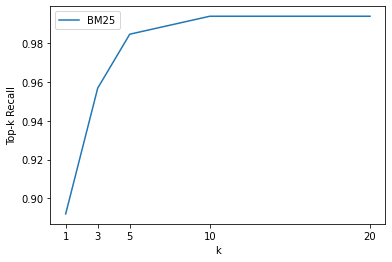

In [51]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([bm25_topk_df], ["BM25"])

#### Dense Passage Retrieval

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="images/chapter07_dpr.png" id="dpr"/>

In [52]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

INFO:haystack.modeling.utils:Using devices: CUDA:0
INFO:haystack.modeling.utils:Number of GPUs: 1


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find facebook/dpr-question_encoder-single-nq-base locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded facebook/dpr-question_encoder-single-nq-base


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.
INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find facebook/dpr-ctx_encoder-single-nq-base locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded facebook/dpr-ctx_encoder-single-nq-base


In [53]:
document_store.update_embeddings(retriever=dpr_retriever)

INFO:haystack.document_stores.elasticsearch:Updating embeddings for all 1615 docs ...


Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

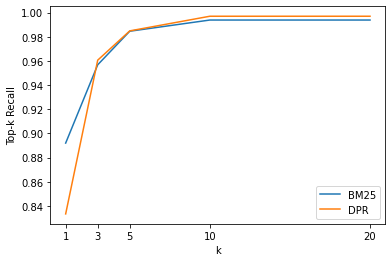

In [54]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

### Evaluating the Reader

In [55]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [56]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


The evaluation of a reader can be done by creating a pipeline that consists only of a single node: a reader. In this case, the `pipeline.eval()` gets the relevant documents as direct input from the labels.

In [57]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

/usr/local/lib/python3.8/dist-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len


In the first version no_answer labels weren't taken into account. Because there are quite many of them in the evaluation dataset the numbers differ significantly compared to the first version (EM was at ~0.07 and f1 at ~0.25).

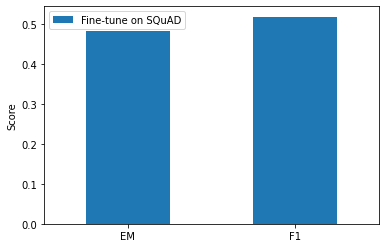

In [58]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

### Domain Adaptation

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="images/chapter07_squad-schema.png" id="squad-schema"/>

In [59]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [60]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [61]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [62]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:Loading train set from: electronics-train.json 
INFO:haystack.modeling.data_handler.data_silo:Multiprocessing disabled, using a single worker to convert 1265dictionaries to pytorch datasets.
Preprocessing Dataset electronics-train.json: 100%|██████████| 1265/1265 [00:00<00:00, 12520.34 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard 

In [63]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)

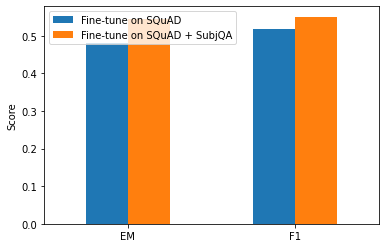

In [64]:
plot_reader_eval(reader_eval)

In [65]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

INFO:haystack.modeling.utils:Using devices: CUDA:0
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find microsoft/MiniLM-L12-H384-uncased locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded microsoft/MiniLM-L12-H384-uncased
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.infer:Got ya 2 parallel workers to do inference ...
INFO:haystack.modeling.infer: 0     0  
INFO:haystack.modeling.infer:/w\   /w\ 
INFO:haystack.modeling.infer:/'\   / \ 


In [66]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:Loading train set from: electronics-train.json 
INFO:haystack.modeling.data_handler.data_silo:Multiprocessing disabled, using a single worker to convert 1265dictionaries to pytorch datasets.
Preprocessing Dataset electronics-train.json: 100%|██████████| 1265/1265 [00:00<00:00, 12274.97 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard 

In [67]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)

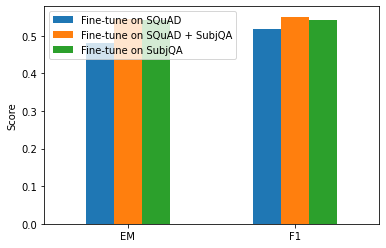

In [68]:
plot_reader_eval(reader_eval)

### Evaluating the Whole QA Pipeline

In [69]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

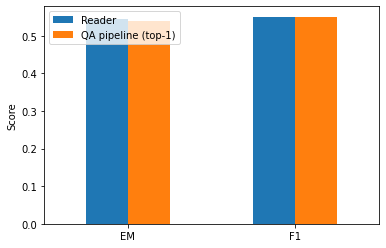

In [70]:
#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

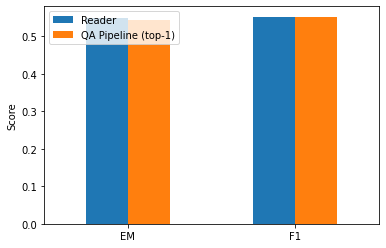

In [71]:
# Or get QA pipeline and Reader metrics in one shot:
# Reader evaluation is run a second time using simulated perfect retriever results
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader run in isolation with simulated perfect retriever
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

## Going Beyond Extractive QA

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="images/chapter07_rag-architecture.png" id="rag"/>

### Retrieval-Augmented Generation

In [72]:
from haystack.nodes import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1


Downloading:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizerFast'.


Downloading:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

Some weights of RagTokenForGeneration were not initialized from the model checkpoint at facebook/rag-token-nq and are newly initialized: ['rag.generator.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
from haystack.pipelines import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [74]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query, 
                     params={"Retriever": {"top_k":5, 
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})  
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx].answer}")

In [75]:
generate_answers(query)

/usr/local/lib/python3.8/dist-packages/transformers/models/rag/tokenization_rag.py:92: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation_utils.py:1747: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


Question: Is it good for reading? 

Answer 1:  the screen is absolutely beautiful
Answer 2:  the Screen is absolutely beautiful
Answer 3:  Kindle fire


In [76]:

generate_answers("What is the main drawback?")

Question: What is the main drawback? 

Answer 1:  the price
Answer 2:  no flash support
Answer 3:  the cost
